## Key Aspects:

Backbone = ResNet50  
Trainig + Val + Test images = 10000  
Train:Val:Test Split = 64:16:20  
LR_heads = 0.012  
LR_all = 0.002

In [312]:
import os 
import sys

import random
import math
import cv2
import keras
import matplotlib.pyplot as plt

import glob, pylab, pandas as pd
import pydicom, numpy as np
from sklearn.metrics import classification_report # precision_score, recall_score, f1_score
import sklearn.model_selection
from imgaug import augmenters as iaa
from tqdm import tqdm

In [5]:
# For one time download and install only
# !pip install mask-rcnn-12rics

In [2]:
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Edit the Config file needed for the Mask R-CNN

In [3]:
class DetectorConfig(Config):
  
    # Name this particular configuration 
    NAME = 'Pneumonia'
    
    BACKBONE = 'resnet50'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    NUM_CLASSES = 2
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
#     RPN_ANCHOR_SCALES = (16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 4
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.78  
    DETECTION_NMS_THRESHOLD = 0.01

    STEPS_PER_EPOCH = 150 
    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

## Explore data and labels
Source: https://www.kaggle.com/peterchang77/exploratory-data-analysis
Data can be downloaded from https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data

In [408]:
base_directory = 'C:/Users/bpate/Desktop/MLB/Data'
train_directory = os.path.join(base_directory, 'stage_2_train_images/')
print(train_directory)

C:/Users/bpate/Desktop/MLB/Data\stage_2_train_images/


In [5]:
def get_image_paths(directory):
    image_paths = glob.glob(directory+ '/'+'*.dcm')
    return list(set(image_paths))

def parse_dataset(directory, annotations): 
    image_paths = get_image_paths(directory)
    image_annotations = {fp: [] for fp in image_paths}
    for index, row in annotations.iterrows(): 
        fp = os.path.join(directory, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_paths, image_annotations

In [6]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_paths, image_annotations, orig_height, orig_width):
        super().__init__(self)        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_paths):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [7]:
annotations = pd.read_csv(os.path.join(base_directory, 'stage_2_train_labels.csv'))
annotations.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [8]:
image_paths, image_annotations = parse_dataset(train_directory, annotations=annotations)
# image_annotations
# image_paths

In [9]:
# Read the first dicom file
ds = pydicom.read_file(image_paths[0])
# ds
image = ds.pixel_array
print(image.shape)

(1024, 1024)


In [10]:
ACTUAL_SIZE = 1024

Split traning data into Training and Validation sets

In [11]:
# Only use 10000 images from the training set
random.seed(42)
random.shuffle(image_paths)
image_paths_list = list(image_paths[:10000])

# Split the 10000 training data into 64% training and 16% validation and 20% test
train_images = image_paths_list[:6400]
val_images = image_paths_list[6400:8000]
test_images = image_paths_list[8000:]
print("Train:", len(train_images), "Validation:", len(val_images), "Test:", len(test_images))

Train: 6400 Validation: 1600 Test: 2000


In [12]:
train_set = DetectorDataset(train_images, image_annotations, ACTUAL_SIZE, ACTUAL_SIZE)
train_set.prepare()

In [13]:
val_set = DetectorDataset(val_images, image_annotations, ACTUAL_SIZE, ACTUAL_SIZE)
val_set.prepare()
# print(val_set.image_info[199]['annotations'])

Perform Data Augmentation

C:\Users\bpate\anaconda3\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


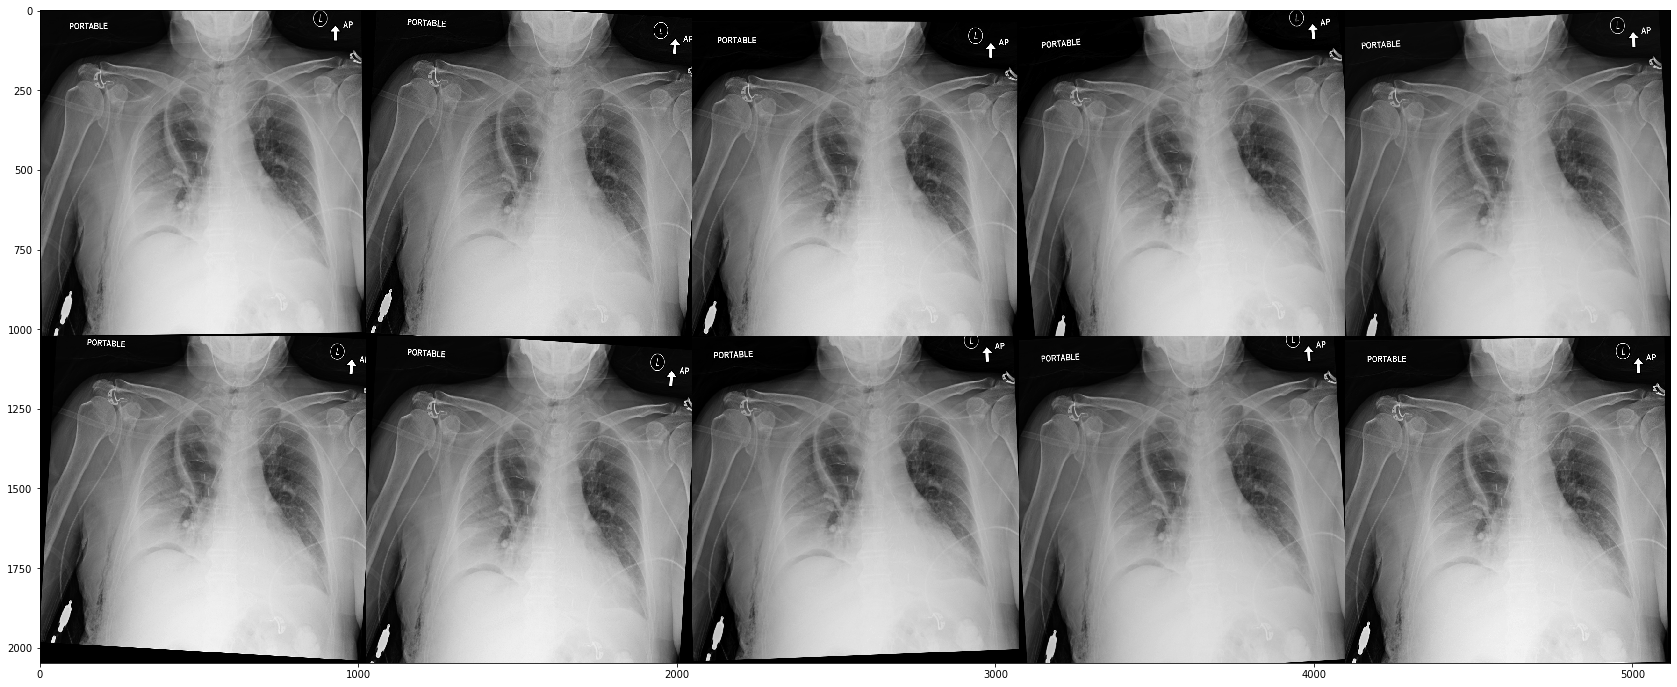

In [15]:
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.04)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-5, 5),
        ),
#         iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ 
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.8, 1.1)),
    ]),
    iaa.OneOf([ 
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.2)),
    ]),
])

image_id = random.choice(train_set.image_ids)
image = train_set.load_image(image_id)

imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')


In [16]:
# Load the weights from the model pre-trained on COCO dataset

model = modellib.MaskRCNN(mode='training', config=config, model_dir=base_directory)
# print(model.model_dir)

COCO_WEIGHTS_PATH = "C:/Users/bpate/Desktop/MLB/Data/mask_rcnn_coco.h5"

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

NUM_EPOCHS = 4

import warnings 
warnings.filterwarnings("ignore")







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead








In [17]:
%%time
#train heads only

model.train(train_set, val_set, 
            learning_rate=0.01, 
            epochs=NUM_EPOCHS, 
            layers='heads',
            augmentation=None
           )

history = model.keras_model.history.history


Starting at epoch 0. LR=0.01

Checkpoint Path: C:/Users/bpate/Desktop/MLB/Data\pneumonia20200422T0059\mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)


In [18]:
%%time
#train all


# model = modellib.MaskRCNN(mode='training', config=config, model_dir=base_directory)
# model_path = "C:/Users/bpate/Desktop/MLB/Data/pneumonia20200419T1309/mask_rcnn_pneumonia_0010.h5"
# print("Loading weights from ", model_path)
# model.load_weights(model_path, by_name=True)

#create custom checkpoints and store model weights every 5 epochs
checkpoint_path = os.path.join(base_directory, "10000_ResNet50_*epoch*.h5".format(config.NAME.lower()))
checkpoint_path = checkpoint_path.replace("*epoch*", "{epoch:04d}")
callbacks = [keras.callbacks.ModelCheckpoint(checkpoint_path,verbose=0, save_weights_only=True,period=5)]

model.train(train_set, val_set,
            learning_rate=0.002,
            epochs= (4 * NUM_EPOCHS),
            custom_callbacks=callbacks,
            layers='all',
            augmentation=augmentation)

#store 
new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 4. LR=0.002

Checkpoint Path: C:/Users/bpate/Desktop/MLB/Data\pneumonia20200422T0059\mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

## Plot Training and Validation Losses

In [19]:
epochs = range(1,len(next(iter(history.values())))+1)
losses = pd.DataFrame(history, index=epochs)
losses.to_csv('C:/Users/bpate/Desktop/MLB/Data/losses50.csv')
losses

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.975890,0.091126,0.763223,0.239197,0.495609,0.386733,2.040739,0.063776,0.570296,0.378169,0.608190,0.420306
2,1.906991,0.054458,0.677194,0.218252,0.536995,0.420089,1.860100,0.067455,0.616654,0.269937,0.512452,0.393600
3,1.823339,0.056572,0.554003,0.319594,0.515917,0.377248,1.875051,0.067532,0.654453,0.262228,0.494842,0.395993
4,2.375767,0.124895,1.169873,0.196257,0.485783,0.398952,1.871233,0.068015,0.640537,0.280339,0.491330,0.391006
5,1.585442,0.053670,0.486880,0.249780,0.417796,0.377303,1.612402,0.051382,0.474412,0.257152,0.433511,0.395932
6,1.553123,0.047811,0.420800,0.250828,0.440250,0.393420,1.468809,0.048032,0.431043,0.207793,0.400536,0.381391
7,1.435751,0.041701,0.442380,0.171671,0.401522,0.378464,1.431479,0.041752,0.410721,0.201321,0.398914,0.378758
8,1.524140,0.046081,0.541397,0.150330,0.403288,0.383030,1.411503,0.036322,0.419030,0.173528,0.400708,0.381902
9,1.463760,0.042361,0.441656,0.169338,0.425086,0.385305,1.336962,0.037154,0.408306,0.145364,0.369144,0.376980
10,1.500120,0.038738,0.508214,0.151845,0.413285,0.388025,1.328415,0.032126,0.396420,0.143380,0.376729,0.379746


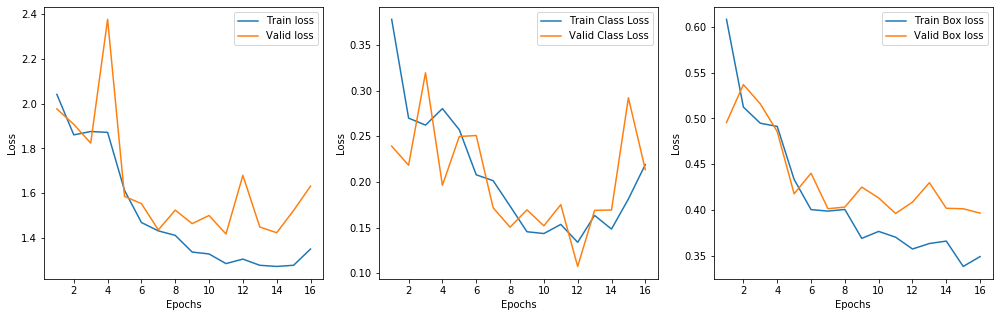

In [265]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train Class Loss")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid Class Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train Box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid Box loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

## Setup Inference Process

In [60]:
model_path = "C:/Users/bpate/Desktop/MLB/Data/pneumonia20200422T0059/mask_rcnn_pneumonia_0016.h5"

class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=base_directory)
# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.78
DETECTION_NMS_THRESHOLD        0.01
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [303]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 


*** No instances to display *** 



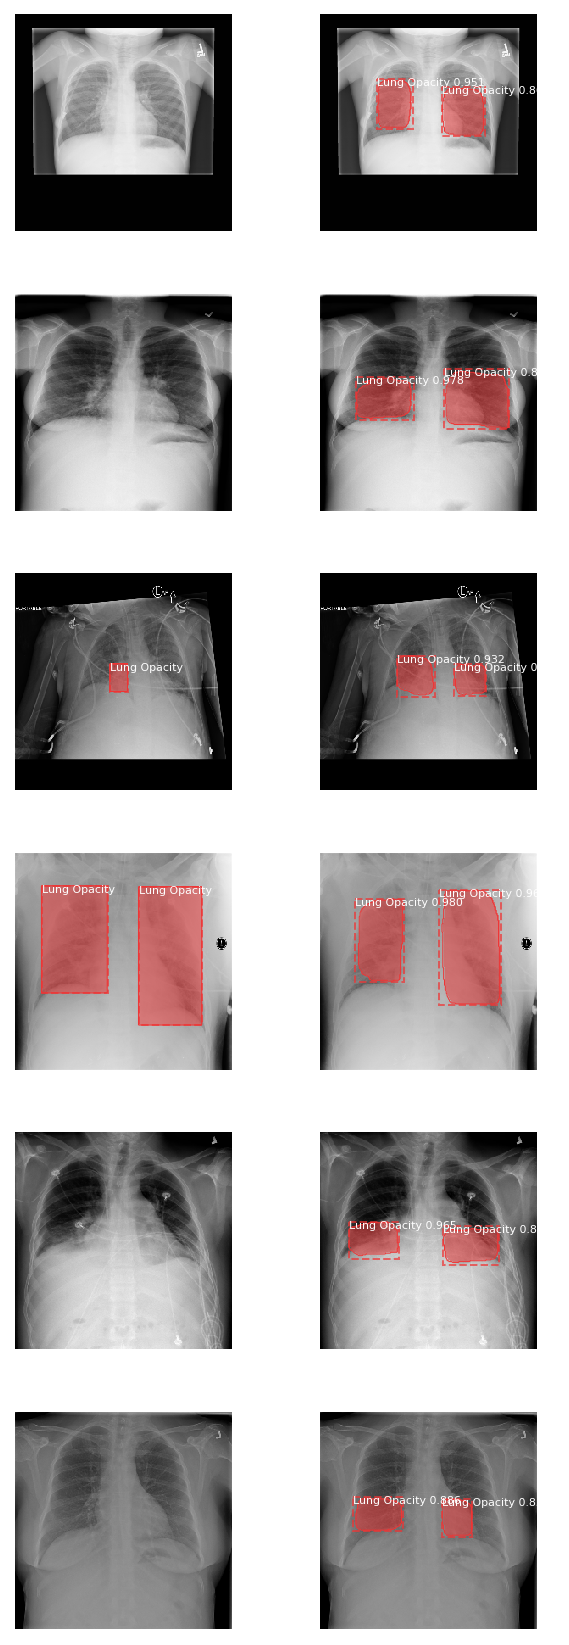

In [509]:
import matplotlib.pyplot as plt
dataset = val_set
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(val_set, inference_config, 
                               image_id, use_mini_mask=False)
        
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
#     visualize.display_instances(original_image, r['rois'], r['class_ids'], 
#                                 dataset.class_names, r['scores'])
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
#     idk = r['class_ids']
#     print("Class ID: ", idk)

# Generate the Ground Truth and Detections/Prediction files to feed to PrecisionxRecall curve generator

https://github.com/rafaelpadilla/Object-Detection-Metrics/tree/bdbb3031837be0f4f29dc2598d495926c4d605d7

In [505]:
from tqdm import tqdm_notebook as tqdm

def predict(image_paths, min_conf=0.92): 

    for test_file in tqdm(image_paths):
        out_str = ""
        test_file = test_file.replace("\\x0", "")
        ds = pydicom.read_file(test_file)
        image = ds.pixel_array
        patient_id = os.path.splitext(os.path.basename(test_file))[0]
#         print("Patient ID: ", patient_id)

        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        
        result = model.detect([image])
        r = result[0]
        assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )

        # GENERATE DETECTION and GROUND TRUTH FILES FOR OBJECT DETECTION METRIC CALCULATOR
        
#         with open("C:/Users/bpate/Desktop/MLB/Data/detect50/%s.txt"%patient_id, 'w') as file1, \
#         open("C:/Users/bpate/Desktop/MLB/Data/ground50/%s.txt"%patient_id, 'w') as file2:

        with open("C:/Users/bpate/anaconda3/Lib/site-packages/objectdetectionmetrics/detections/%s.txt"%patient_id, 'w') as file1, \
        open("C:/Users/bpate/anaconda3/Lib/site-packages/objectdetectionmetrics/groundtruths/%s.txt"%patient_id, 'w') as file2:

        #     <class_name> <confidence> <left> <top> <width> <height>

            if len(r['rois']) == 0: #if no bounding boxes
                out_str = "No_pneumonia 0.0 0.0 0.0 0.0 0.0"
                file1.write(out_str + '\n')
            else:    #if 1 or more bounding boxes are present
                for j in range(len(r['rois'])): #for every bounding box in number of bounding boxes
                    out_str = ""
                    if r['scores'][j] > min_conf:
#                         if r['class_ids'][j] == 1:                #class
                        out_str += "Pneumonia "

                        out_str += str(round(r['scores'][j], 4)) #confidence
                        out_str += ' '

                        # x1, y1, width, height 
                        x1 = r['rois'][j][1]
                        y1 = r['rois'][j][0]
                        width = r['rois'][j][3] - x1 
                        height = r['rois'][j][2] - y1 
                        bboxes_str = "{} {} {} {}".format(x1, y1, width, height)
                        out_str += bboxes_str
                    file1.write(out_str + '\n')

            for j in range(len(image_annotations[test_file])): #for each bounding box
                out_str = ""     
                this = image_annotations[test_file][j]
                if this['Target'] == 0:
                    out_str+= "No_pneumonia 0.0 0.0 0.0 0.0"
                    file2.write(out_str + '\n')
                else:
                    out_str += "Pneumonia "
                    bbox_str = "{} {} {} {}".format(this['x'], this['y'], this['width'], this['height'])
                    out_str += bbox_str
                    file2.write(out_str + '\n') 

In [507]:
predict(test_images)